In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [2]:
def scatter_plot(x, y, xlabel, ylabel, title):
    g = sns.JointGrid()
    sns.scatterplot(x=x, y=y, ax=g.ax_joint) # can set s=10
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x) 
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

    g.ax_joint.set(xlabel=xlabel, ylabel=ylabel)

    g.ax_joint.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], linewidth=1.0, color='black', linestyle='solid', label='Equality Line')

    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b

    g.ax_joint.plot(x2, y2, 'r--', linewidth=3.0, label='Linear Regression Line')
    g.ax_joint.legend()
    
    pearson_correlation = pearsonr(x,y)[0]

    g.ax_joint.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    print("Reg Slope:", w)

    g.fig.suptitle(title, y=1.05)

    plt.show()

def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
#     plt.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    
def get_corr_plot(array, title, labels, partial_correlation=False, fig_size=None, fix_colorbar_scale=False):
    with sns.axes_style("white"):
        if fig_size == None:
            fig = plt.figure() # can set figsize=(fig_size = 12.8, fig_size)
        else:
            fig = plt.figure(figsize=(fig_size, fig_size))
        ax = fig.add_subplot(111)
        if fix_colorbar_scale == True:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis', vmin=0, vmax=1)
        else:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis')
        fig.colorbar(cax)
        if partial_correlation == False:
            intro = "Pearson R"
        else:
            intro = "Partial Correlation"
        plt.title("{} for {}".format(intro, title), fontsize=fig_size+5 if fig_size != None else 10)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        plt.show()

def correlation_plot(df, key, title, partial_correlation= False, fig_size=None, fix_colorbar_scale=False):
    
    names = df.modality.to_list()
    
    if partial_correlation == False:
        corr_df1 = []
        for idx1 in range(len(df)):
            df1 = df.iloc[idx1].dataframe
            corr_df2 = []
            for idx2 in range(len(df)):
                df2 = df.iloc[idx2].dataframe
                r, _ = pearsonr(df1[key], df2[key])
                corr_df2.append(r)
            corr_df2 = np.array(corr_df2).astype('float32')
            corr_df1.append(corr_df2)
        corr_df1 = np.array(corr_df1).astype('float32')
        get_corr_plot(corr_df1, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
    else:
        tmp_dct = {}
        for idx in range(len(df)):
            tmp_df = df.iloc[idx].dataframe[key]
            tmp_dct[names[idx]] = tmp_df.to_numpy()
        pcorr_df = pd.DataFrame.from_dict(tmp_dct)
        del tmp_dct, tmp_df
        
        # This implementation comes from https://pingouin-stats.org/index.html
        # Source code here for pcorr: https://github.com/raphaelvallat/pingouin/blob/72e447d539f8cfbd6b9c9c5041e267de748fe124/pingouin/correlation.py

        V = pcorr_df.cov()
        Vi = np.linalg.pinv(V, hermitian=True)
        D = np.diag(np.sqrt(1 / np.diag(Vi)))
        pcor = -1 * (D @ Vi @ D)
        pcor[np.diag_indices_from(pcor)] = 1
        get_corr_plot(pcor, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
        
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)

In [3]:
df = pd.read_pickle('female_test_prototype.pkl')
# df = pd.read_pickle('female_train.pkl')
# df = pd.read_pickle('female_testA.pkl')

In [4]:
df.iloc[0].dataframe

,Unnamed: 0,target_age,output_age,age_delta,loss,output_age_decon,age_delta_decon
0,24726222,61.914726,57.460182,-4.454544,19.842962,52.859442,-9.055284
1,24642634,68.817620,73.599106,4.781486,22.862614,84.614846,15.797226
2,25463415,58.056694,60.867516,2.810821,7.900718,59.563809,1.507115
3,21026392,67.284820,64.137940,-3.146881,9.902861,65.998788,-1.286032
4,23521455,53.088700,54.396850,1.308151,1.711260,46.831943,-6.256757
...,...,...,...,...,...,...,...
495,22983466,75.766556,71.593414,-4.173141,17.415110,80.668389,4.901833
496,25441855,55.924540,57.292084,1.367542,1.870172,52.528688,-3.395852
497,22692931,54.656506,60.476880,5.820373,33.876747,58.795182,4.138676
498,23453524,67.078880,68.133580,1.054703,1.112398,73.860722,6.781842


In [5]:
# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

# correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
                 partial_correlation=False, fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
#                  partial_correlation=False, fix_colorbar_scale=True)

ValueError: x and y must have the same length.

In [6]:
correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
                 partial_correlation=True, fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
#                  partial_correlation=True, fix_colorbar_scale=True)

ValueError: All arrays must be of the same length

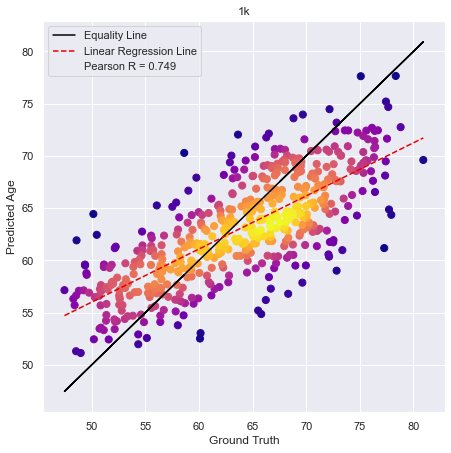

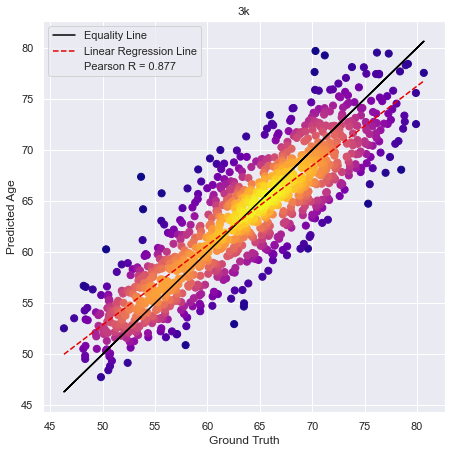

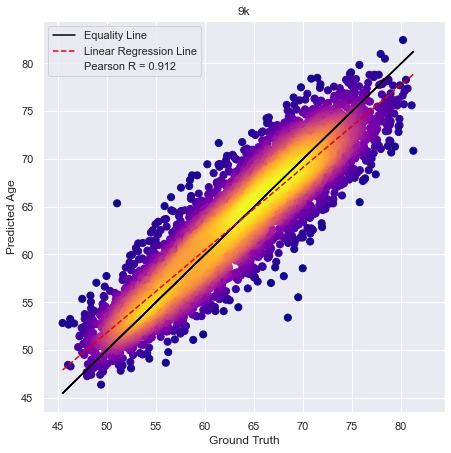

In [7]:
# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.mean_output_age, xlabel='Ground Truth', 
#                                ylabel='Predicted Age', title=name_mod, set_scale=True)

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age, xlabel='Ground Truth', 
                               ylabel='Predicted Age', title=name_mod, set_scale=True)

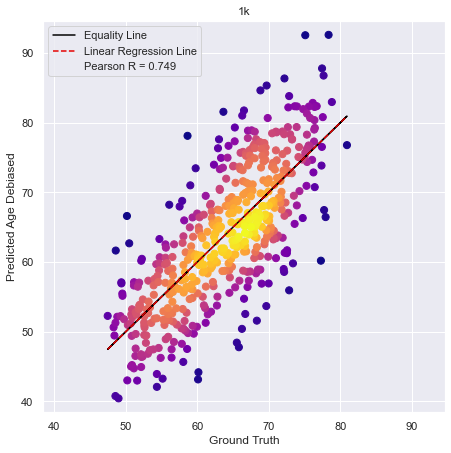

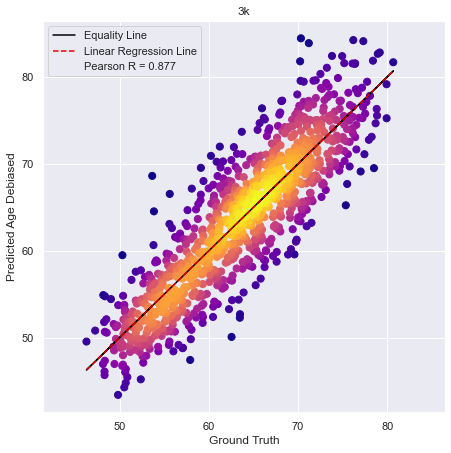

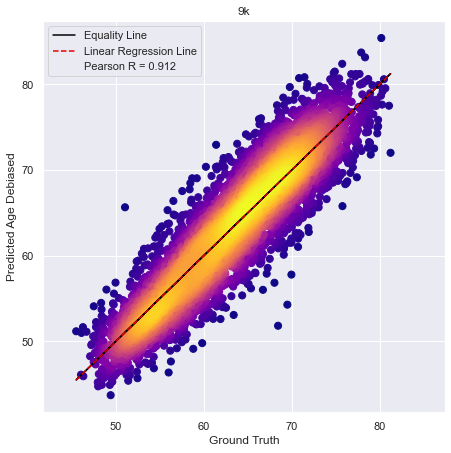

In [8]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Debiased', title=name_mod, set_scale=True)

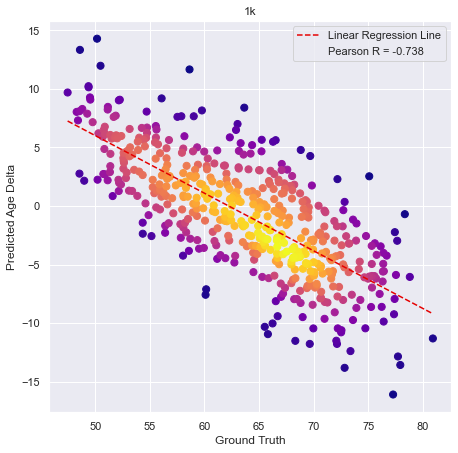

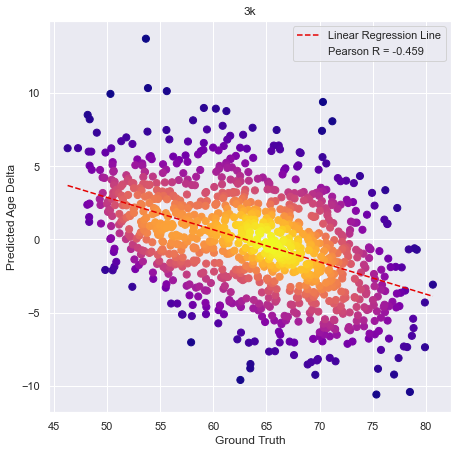

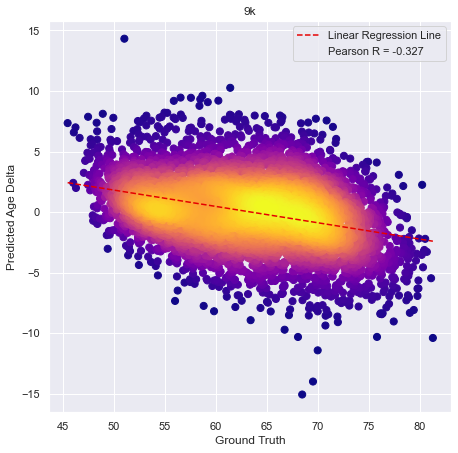

In [9]:
# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.mean_age_delta, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Delta', title=name_mod, set_scale=False, 
#                                equality_line=False)

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.age_delta, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta', title=name_mod, set_scale=False, 
                               equality_line=False)

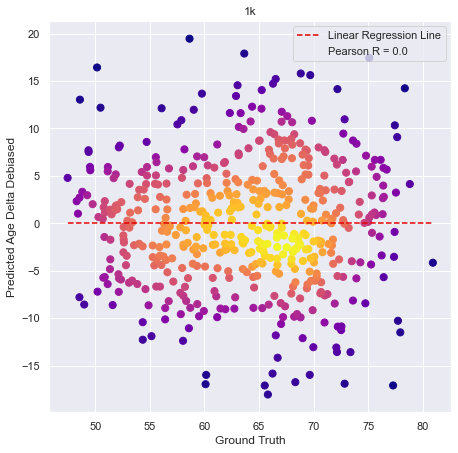

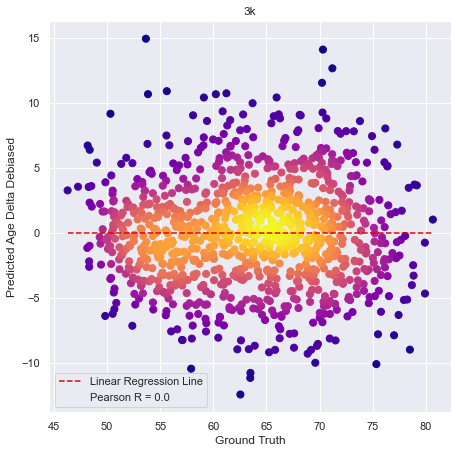

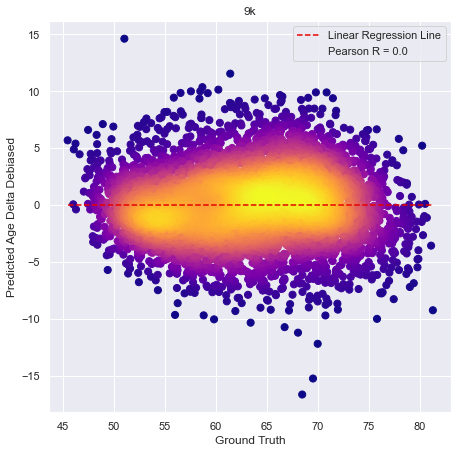

In [10]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.age_delta_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Debiased', title=name_mod, set_scale=False, 
                               equality_line=False)

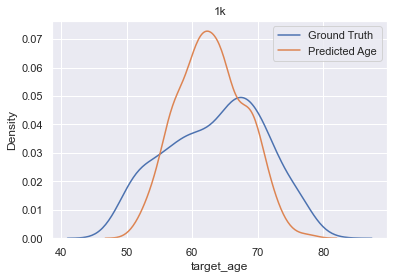

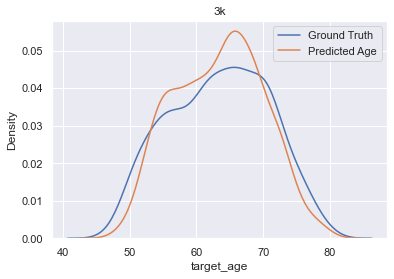

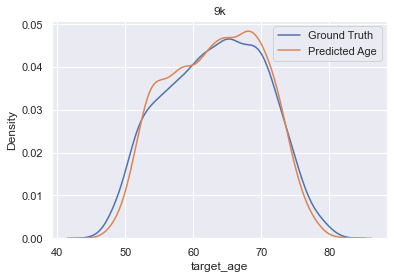

In [11]:
# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = kde_plot(x=df_mod.target_age, y=df_mod.mean_output_age, 
#                    xlabel='Ground Truth', ylabel='Predicted Age',
#                    title=name_mod)
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = kde_plot(x=df_mod.target_age, y=df_mod.output_age, 
                   xlabel='Ground Truth', ylabel='Predicted Age',
                   title=name_mod)

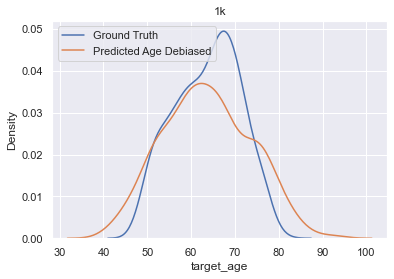

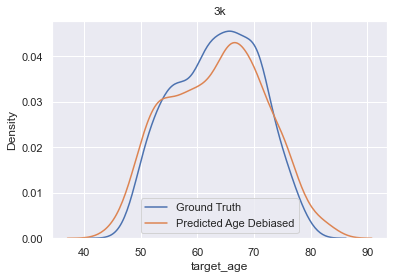

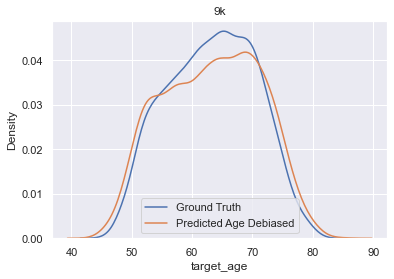

In [12]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = kde_plot(x=df_mod.target_age, y=df_mod.output_age_decon, 
                   xlabel='Ground Truth', ylabel='Predicted Age Debiased',
                   title=name_mod)